## Parsing : Document to CSV

In [1]:
import os
import csv
from PyPDF2 import PdfReader

INPUT_DIR = 'papers_adhd'
OUTPUT_DIR = 'papers_adhd_csvs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

output_csv = os.path.join(OUTPUT_DIR, 'all_papers.csv')

with open(output_csv, mode='w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(
        csvfile,
        quoting=csv.QUOTE_MINIMAL,    # only quote fields when needed
        quotechar='"',                # wrap fields containing special chars in "
        escapechar='\\'               # escape embedded quotechars with backslash
    )
    writer.writerow(['page_text', 'source_file', 'page_number'])

    for fname in os.listdir(INPUT_DIR):
        if not fname.lower().endswith('.pdf'):
            continue

        pdf_path = os.path.join(INPUT_DIR, fname)
        try:
            reader = PdfReader(pdf_path)
        except Exception as e:
            print(f'[!] Could not open "{fname}": {e}')
            continue

        for page_num, page in enumerate(reader.pages, start=1):
            try:
                text = page.extract_text() or ''
            except Exception as e:
                text = f'[Error on page {page_num}: {e}]'

            # remove any null bytes that can break the CSV writer
            text = text.replace('\x00', '')

            writer.writerow([text, fname, page_num])

        print(f'  → Processed "{fname}" ({len(reader.pages)} pages)')

print(f'All done! Combined CSV written to:\n  {output_csv}')


  → Processed "paper1.pdf" (28 pages)
  → Processed "paper10.pdf" (2 pages)
  → Processed "paper11.pdf" (3 pages)
  → Processed "paper12.pdf" (13 pages)
  → Processed "paper13.pdf" (28 pages)
  → Processed "paper14.pdf" (13 pages)
  → Processed "paper15.pdf" (13 pages)
  → Processed "paper16.pdf" (17 pages)
  → Processed "paper17.pdf" (15 pages)
  → Processed "paper18.pdf" (22 pages)
  → Processed "paper19.pdf" (11 pages)
  → Processed "paper2.pdf" (14 pages)
  → Processed "paper20.pdf" (8 pages)
  → Processed "paper21.pdf" (24 pages)
  → Processed "paper22.pdf" (7 pages)
  → Processed "paper23.pdf" (4 pages)
  → Processed "paper24.pdf" (3 pages)
  → Processed "paper25.pdf" (31 pages)
  → Processed "paper26.pdf" (23 pages)
  → Processed "paper27.pdf" (11 pages)
  → Processed "paper28.pdf" (10 pages)
  → Processed "paper29.pdf" (10 pages)
  → Processed "paper3.pdf" (13 pages)
  → Processed "paper30.pdf" (17 pages)
  → Processed "paper4.pdf" (15 pages)
  → Processed "paper5.pdf" (11 page

## Understanding Data

In [2]:
import pandas as pd

# df= pd.read_csv(r"papers_adhd_csvs/all_papers.csv", encoding='utf-8', escapechar='\\')
# df['page_text'] = df['page_text'].str.replace(r'\\', '', regex=True)

df= pd.read_csv(r"papers_adhd_csvs/all_papers.csv", encoding='utf-8')

print(f'Number of rows: {len(df)}')
print(f'Number of columns: {len(df.columns)}')
print(f'Columns: {df.columns.tolist()}')

print(f'First 5 rows:\n{df.head()}')

max_length = df['page_text'].str.len().max()
print(f'Max length of page_text: {max_length}')

max_length = df['page_text'].str.len().mean()
print(f'Mean length of page_text: {max_length}')

Number of rows: 396
Number of columns: 3
Columns: ['page_text', 'source_file', 'page_number']
First 5 rows:
                                           page_text source_file  page_number
0  Exploring N-Back Cognitive Training for Childr...  paper1.pdf            1
1  prevalence of ADHD, the chances are high that ...  paper1.pdf            2
2  these interventions, teachers (behavioral clas...  paper1.pdf            3
3  inhibition and working memory-demanding execut...  paper1.pdf            4
4  learning or attention disorders. Based on our ...  paper1.pdf            5
Max length of page_text: 10525
Mean length of page_text: 3996.969696969697


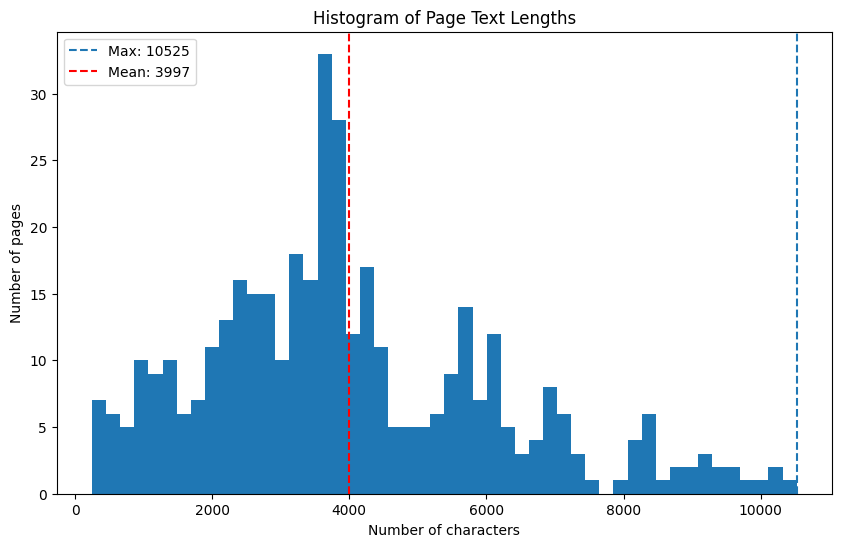

Max length of page_text: 10525
Mean length of page_text: 3996.97


In [3]:
# Histogram of page_text lengths
import matplotlib.pyplot as plt
# Compute the length of each page's text
lengths = df['page_text'].astype(str).str.len()

# Plot a histogram of those lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50)
plt.title('Histogram of Page Text Lengths')
plt.xlabel('Number of characters')
plt.ylabel('Number of pages')

# Mark the max and mean
max_len = lengths.max()
mean_len = lengths.mean()
plt.axvline(max_len, linestyle='--',  label=f'Max: {max_len:.0f}')
plt.axvline(mean_len, linestyle='--',color='r', label=f'Mean: {mean_len:.0f}')
plt.legend()

plt.show()

# Print out the numeric stats
print(f'Max length of page_text: {max_len}')
print(f'Mean length of page_text: {mean_len:.2f}')







## Chunking

In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from semchunk import chunkerify
from tqdm import tqdm
import numpy as np
import json

# === CONFIGURATION ===
INPUT_CSV = 'papers_adhd_csvs/all_papers.csv'
OUTPUT_CSV = 'papers_adhd_csvs/all_papers_chunked_embeddings.csv'

TOKENIZER_MODEL = "medicalai/ClinicalBERT"
CHUNK_SIZE = 256
TOKEN_THRESHOLD = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === LOAD DATA ===
df = pd.read_csv(INPUT_CSV, encoding='utf-8')
df['page_text'] = df['page_text'].astype(str)

# === INITIALIZE TOKENIZER, MODEL, CHUNKER ===
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
model = AutoModel.from_pretrained(TOKENIZER_MODEL).to(DEVICE)
model.eval()

chunker = chunkerify(tokenizer, CHUNK_SIZE)

# === EMBEDDING FUNCTION (CLS token approach) ===
@torch.no_grad()
def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=TOKEN_THRESHOLD).to(DEVICE)
    outputs = model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
    return cls_embedding.squeeze().cpu().numpy()

# === MAIN PROCESSING LOOP ===
chunked_rows = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row['page_text']
    token_ids = tokenizer.encode(text, add_special_tokens=False)

    if len(token_ids) > TOKEN_THRESHOLD:
        chunks = chunker(text)
    else:
        chunks = [text]

    for c in chunks:
        token_len = len(tokenizer.encode(c, add_special_tokens=False))
        if token_len <= TOKEN_THRESHOLD:
            embedding = get_embedding(c)
            chunked_rows.append({
                'chunk': c,
                'source_file': row.get('source_file', ''),
                'page_number': row.get('page_number', None),
                'token_length': token_len,
                'embedding': embedding.tolist()  # Convert NumPy array to list for JSON serialization
            })
        else:
            print(f"⚠️ Skipped chunk over limit ({token_len} tokens)")


chunked_df = pd.DataFrame(chunked_rows)
chunked_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')

print(f"Chunked data with embeddings saved to: {OUTPUT_CSV}")

C:\Users\mkolla1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
100%|██████████| 396/396 [18:01<00:00,  2.73s/it]


Chunked data with embeddings saved to: papers_adhd_csvs/all_papers_chunked_embeddings.csv


=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834 entries, 0 to 1833
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   chunk         1834 non-null   object
 1   source_file   1834 non-null   object
 2   page_number   1834 non-null   int64 
 3   token_length  1834 non-null   int64 
 4   embedding     1834 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.8+ KB
None

=== Sample Rows ===
                                               chunk source_file  page_number  \
0  Exploring N-Back Cognitive Training for Childr...  paper1.pdf            1   
1  Inhibition; attention; working memory training...  paper1.pdf            1   
2  2002 ; Faraone, Biederman, & Mick, 2005 ; Matt...  paper1.pdf            1   
3  prevalence of ADHD, the chances are high that ...  paper1.pdf            2   
4  tasks, including the Wisconsin Card Sorting Te...  paper1.pdf            2   

   token_leng

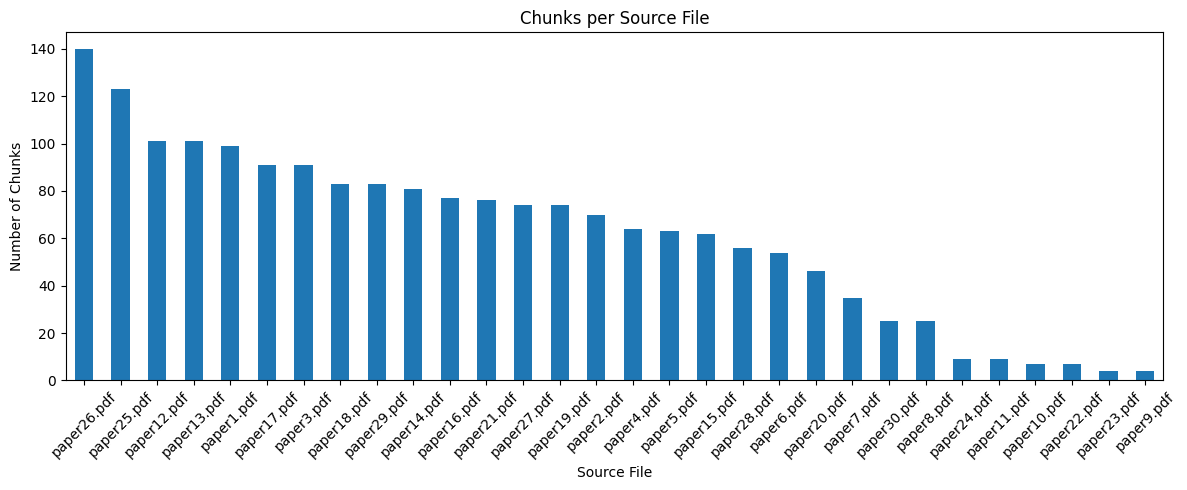

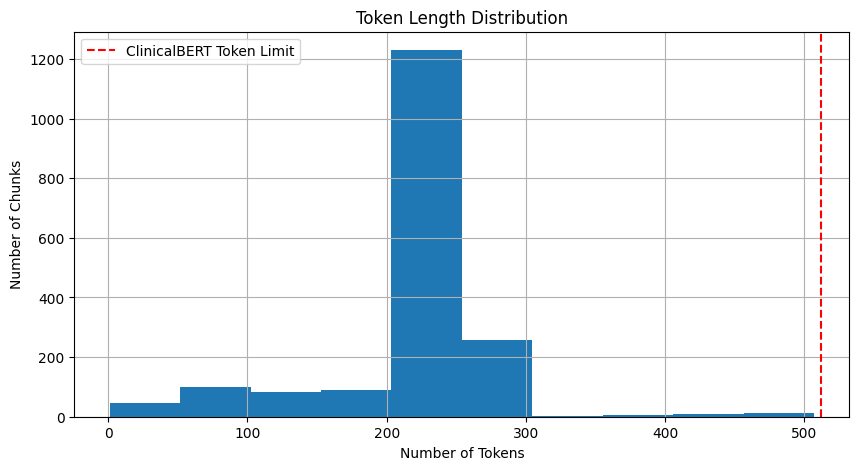

Embedding Matrix Shape: (1834, 768)


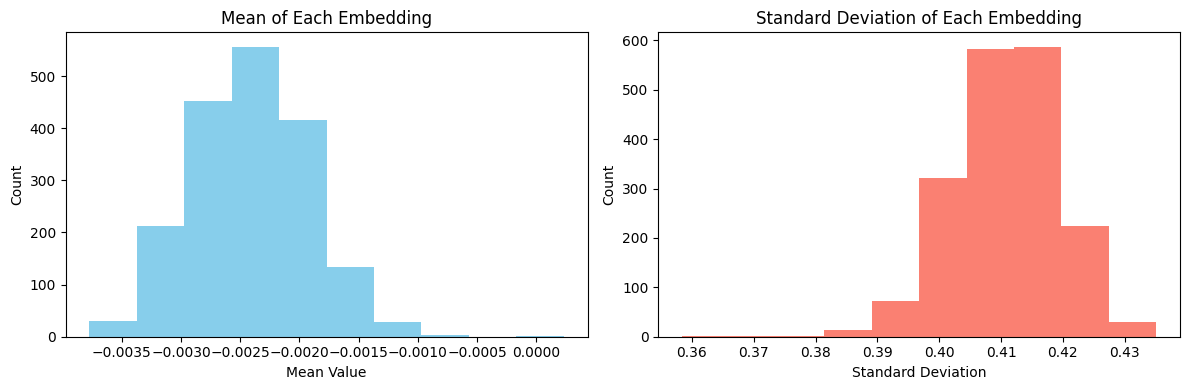

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# === Load the CSV with ClinicalBERT embeddings ===
csv_path = 'papers_adhd_csvs/all_papers_chunked_embeddings.csv'
df = pd.read_csv(csv_path)

# === Convert stringified embeddings back to lists ===
df['embedding'] = df['embedding'].apply(ast.literal_eval)

# === Display structure and sample data ===
print("=== DataFrame Info ===")
print(df.info())
print("\n=== Sample Rows ===")
print(df.head())

# === Chunks per Document ===
if 'source_file' in df.columns:
    plt.figure(figsize=(12, 5))
    df['source_file'].value_counts().plot(kind='bar')
    plt.title('Chunks per Source File')
    plt.xlabel('Source File')
    plt.ylabel('Number of Chunks')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === Token Length Distribution ===
plt.figure(figsize=(10, 5))
df['token_length'].hist()
plt.axvline(512, color='red', linestyle='--', label='ClinicalBERT Token Limit')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Chunks')
plt.legend()
plt.grid(True)
plt.show()

# === Convert Embeddings to NumPy Matrix ===
embedding_matrix = np.array(df['embedding'].tolist())
print("Embedding Matrix Shape:", embedding_matrix.shape)

# === Embedding Mean and Std Histograms ===
embedding_means = embedding_matrix.mean(axis=1)
embedding_stds = embedding_matrix.std(axis=1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(embedding_means, color='skyblue')
plt.title('Mean of Each Embedding')
plt.xlabel('Mean Value')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(embedding_stds, color='salmon')
plt.title('Standard Deviation of Each Embedding')
plt.xlabel('Standard Deviation')
plt.ylabel('Count')

plt.tight_layout()
plt.show()